In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, glob, sys
from astropy.io import fits
import astropy.table
import pandas as pd
import astropy.units as u
from scipy import interpolate

In [2]:
from lmfit import models, Parameters, Parameter, Model
from lmfit.models import LinearModel, ConstantModel

In [3]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('large')

In [4]:
wavelength = np.linspace(3550, 9850, (9850-3550)*10)
wavelength_nm = wavelength/10
wavelength_um = wavelength/10000
sky_unit = 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom * u.arcsec**2)
area = 1 * u.arcsec ** 2

In [5]:
ext_f1 = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/files/kpnoextinct.dat'
ext_f2 = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/files/ZenithExtinction-KPNO.dat'

ext1 = astropy.table.Table(np.genfromtxt(ext_f1), names=('WAVE','EXT'))
ext2 = astropy.table.Table(np.loadtxt(ext_f2), names = ('WAVE', 'EXT'))

In [6]:
kpno = interpolate.interp1d(ext1['WAVE'], 10**(-0.4*ext1['EXT']), bounds_error=False, fill_value = 0)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


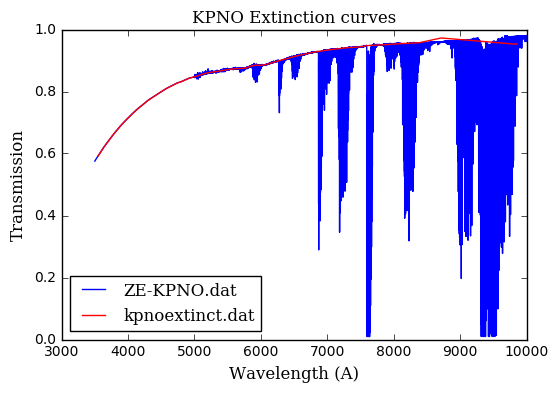

In [7]:
plt.plot(ext2['WAVE'], 10**(-0.4*ext2['EXT']), '-', label = 'ZE-KPNO.dat')
plt.plot(wavelength, kpno(wavelength), 'r-', label = 'kpnoextinct.dat')
plt.title("KPNO Extinction curves",fontproperties=font)
plt.xlabel("Wavelength (A)",fontproperties=font)
plt.ylabel('Transmission',fontproperties=font)
plt.legend(loc = 'lower left', prop=font)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


(7000, 8000)

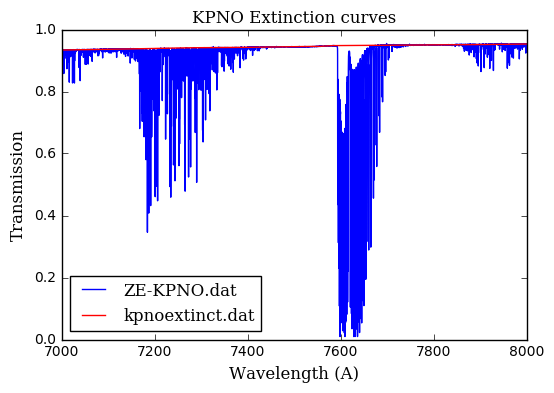

In [8]:
plt.plot(ext2['WAVE'], 10**(-0.4*ext2['EXT']), '-', label = 'ZE-KPNO.dat')
plt.plot(wavelength, kpno(wavelength), 'r-', label = 'kpnoextinct.dat')
plt.title("KPNO Extinction curves",fontproperties=font)
plt.xlabel("Wavelength (A)",fontproperties=font)
plt.ylabel('Transmission',fontproperties=font)
plt.legend(loc = 'lower left', prop=font)
plt.xlim(7000,8000)

In [4]:
sys.path.insert(0,'/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/python/')
import sky_model

In [5]:
obs_meta = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/files/test_ObsMeta.npy')
Mod = sky_model.SkyModel(obs_meta)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


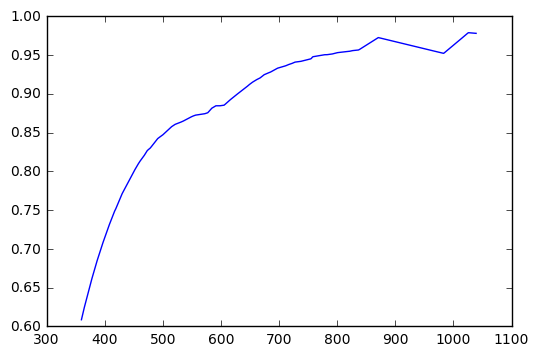

In [6]:
ext_curve = Mod.extinction_curve(1)
plt.plot(Mod.wave_range, ext_curve)

## Parameterization

In [9]:
p = 744 #hPa
H = 2.78 #km at APO
tau_R = (p/1013.25)*(0.00864+6.5*10**(-6)*H) * wavelength_um**(-(3.916 + 0.074*wavelength_um + 0.05/wavelength_um))

In [10]:
k0 = 0.013
alpha = -1.38
k_mie = k0*wavelength_um**(alpha)

In [11]:
trans = np.exp(-tau_R) * 10**(-0.4*k_mie)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


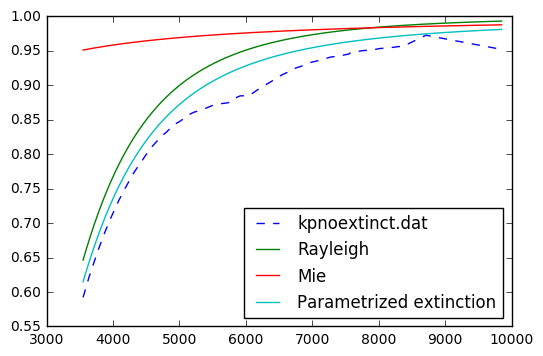

In [12]:
plt.plot(wavelength, kpno(wavelength), '--',label = 'kpnoextinct.dat')
plt.plot(wavelength, np.exp(-tau_R), label = 'Rayleigh')
plt.plot(wavelength, 10**(-0.4*k_mie), label = 'Mie')
plt.plot(wavelength, trans, label = 'Parametrized extinction')
plt.legend(loc='lower right')

## Fit parametrized model

In [13]:
def ext_model(x, p, H, A, B, C, D, E, F, Y,Z):
    wave = x/10000 #um
    tau_R = (p/A)*(B+C*10**(-6)*H) * wave**(-(D + E*wave + F/wave))
    
    k_mie = Y*wave**(-Z+2)
    
    trans = np.exp(-tau_R) * 10**(-0.4*k_mie)
    
    return trans

In [17]:
#M = ext_model(wavelength, 0.00864, 6.5, 3.916, 0.074,0.05, )

In [18]:
mod = Model(ext_model)
params = mod.make_params()
params.add('p', value = 744, min = 0, max = 800, vary=True)
params.add('H', value = 2.096, vary=False)
params.add('A', value = 1013.25, min = 0, vary=False)
params.add('B', value = 0.00864, min = 0, vary=False)
params.add('C', value = 6.5, min = 0, vary=False)
params.add('D', value = 3.916, min=0, vary=False)
params.add('E', value = 0.074, min=0,vary=False)
params.add('F', value = 0.05, min=0,vary=False)
params.add('Y', value = 0.013, min = 0)
params.add('Z', value = 3.38, min=2,max =4)

model = mod.fit(kpno(wavelength), params, x = wavelength,method='leastsq', fit_kws={'maxfev': 2000})
init1 = mod.eval(params, x=wavelength)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


In [19]:
model.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
A      1013        0      inf        0    False     None     None
B   0.00864        0      inf        0    False     None     None
C       6.5        0      inf        0    False     None     None
D     3.916        0      inf        0    False     None     None
E     0.074        0      inf        0    False     None     None
F      0.05        0      inf        0    False     None     None
H     2.096     -inf      inf        0    False     None     None
Y   0.02953        0      inf 4.713e-05     True     None     None
Z     3.723        2        4  0.00654     True     None     None
p     580.8        0      800     1.89     True     None     None


/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


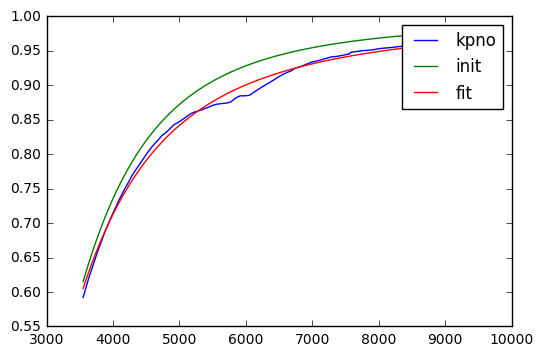

In [20]:
plt.plot(wavelength, kpno(wavelength), label = 'kpno')
plt.plot(wavelength, init1, label = 'init')
plt.plot(wavelength, model.best_fit, label = 'fit')
plt.legend()

In [21]:
mod = Model(ext_model)
params = mod.make_params()
params.add('p', value = 744, min = 0, max = 800, vary=True)
params.add('H', value = 2.78, vary=False)
params.add('A', value = 1013.25, min = 0, vary=False)
params.add('B', value = 0.00864, min = 0, vary=False)
params.add('C', value = 6.5, min = 0, vary=False)
params.add('D', value = 3.916, min=0, vary=False)
params.add('E', value = 0.074, min=0,vary=False)
params.add('F', value = 0.05, min=0,vary=False)
params.add('Y', value = 0.013, min = 0)
params.add('Z', value = 3.38, min=2,max =4)

model = mod.fit(kpno(wavelength), params, x = wavelength,method='leastsq', fit_kws={'maxfev': 2000})
init2 = mod.eval(params, x=wavelength)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


In [22]:
model.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
A      1013        0      inf        0    False     None     None
B   0.00864        0      inf        0    False     None     None
C       6.5        0      inf        0    False     None     None
D     3.916        0      inf        0    False     None     None
E     0.074        0      inf        0    False     None     None
F      0.05        0      inf        0    False     None     None
H      2.78     -inf      inf        0    False     None     None
Y   0.02953        0      inf 4.713e-05     True     None     None
Z     3.723        2        4  0.00654     True     None     None
p     580.5        0      800    1.889     True     None     None


/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


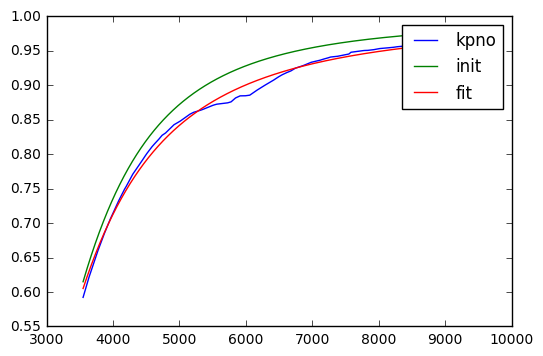

In [23]:
plt.plot(wavelength, kpno(wavelength), label = 'kpno')
plt.plot(wavelength, init2, label = 'init')
plt.plot(wavelength, model.best_fit, label = 'fit')
plt.legend()

/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


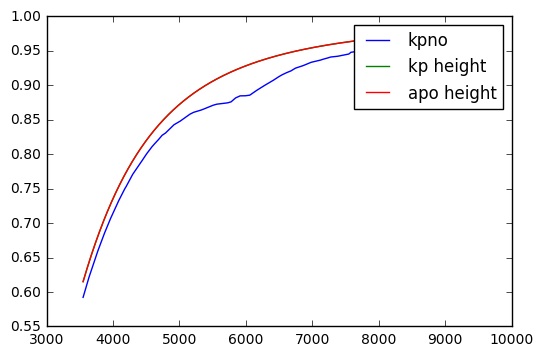

In [24]:
plt.plot(wavelength, kpno(wavelength), label = 'kpno')
plt.plot(wavelength, init1, label = 'kp height')
plt.plot(wavelength, init2, label = 'apo height')
plt.legend()